In [1]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from stargazer.stargazer import Stargazer
from scipy.stats import chi2
import os

pd.options.display.float_format = '{:.2f}'.format

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [2]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games_march2025_cleaned.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')

df = df.drop(columns=['score_rank'])

df.head()

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,682,2434,306,80,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


In [3]:
print(df.columns)

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'positive', 'negative', 'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags',
       'pct_pos_total', 'num_reviews_total', 'pct_pos_recent',
       'num_reviews_recent'],
      dtype='object')


In [4]:
df['posi_nega_ratio'] = df['positive'] / (df['negative'] + 1)
df['log_ccu'] = np.log(df['peak_ccu'] + 1)
df['log_positive'] = np.log(df['positive'] + 1)
df['log_negative'] = np.log(df['negative'] + 1)
df['log_median_playtime'] = np.log1p(df['median_playtime_forever'])
df['log_num_reviews_total'] = np.log1p(df['num_reviews_total'])
df['pub_id'] = pd.factorize(df['publishers'])[0]
df['main_genre'] = df['genres'].str.split(',').str[0]

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_100 = df[df['peak_ccu'] >= 100].copy()
df_100.describe()

df_1000 = df[df['peak_ccu'] >= 1000].copy()
df_1000.describe()

,appid,required_age,price,dlc_count,metacritic_score,achievements,recommendations,user_score,positive,negative,...,num_reviews_total,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_positive,log_negative,log_median_playtime,log_num_reviews_total,pub_id
count,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,...,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00,556.00
mean,1159582.36,3.12,24.13,7.86,33.90,68.87,99785.11,0.00,130304.64,20070.18,...,126768.61,80.91,1619.24,11.79,8.28,10.58,8.56,4.18,-inf,1186.30
std,839507.36,6.50,20.40,19.89,40.92,105.09,258537.62,0.00,380044.04,74436.49,...,428484.78,19.22,5023.59,12.73,1.22,1.69,1.64,3.39,NaN,5166.20
min,240.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.00,-1.00,-1.00,0.00,6.91,0.00,0.00,0.00,-inf,0.00
25%,432995.00,0.00,5.99,0.00,0.00,20.00,7861.50,0.00,16104.75,2081.50,...,16534.75,76.00,241.00,3.91,7.36,9.69,7.64,0.00,9.71,40.00
50%,1017885.00,0.00,19.99,2.00,0.00,47.00,33557.00,0.00,44771.50,5210.00,...,41913.50,86.00,605.00,7.45,7.90,10.71,8.56,5.86,10.64,138.00
75%,1676950.00,0.00,39.99,7.00,81.00,78.00,92085.25,0.00,114633.00,15792.00,...,104438.50,93.00,1358.00,14.72,8.92,11.65,9.67,6.96,11.56,338.25
max,3416070.00,18.00,69.99,252.00,97.00,1328.00,4401572.00,0.00,7480813.00,1135108.00,...,8632939.00,100.00,96473.00,113.49,14.01,15.83,13.94,10.28,15.97,32591.00


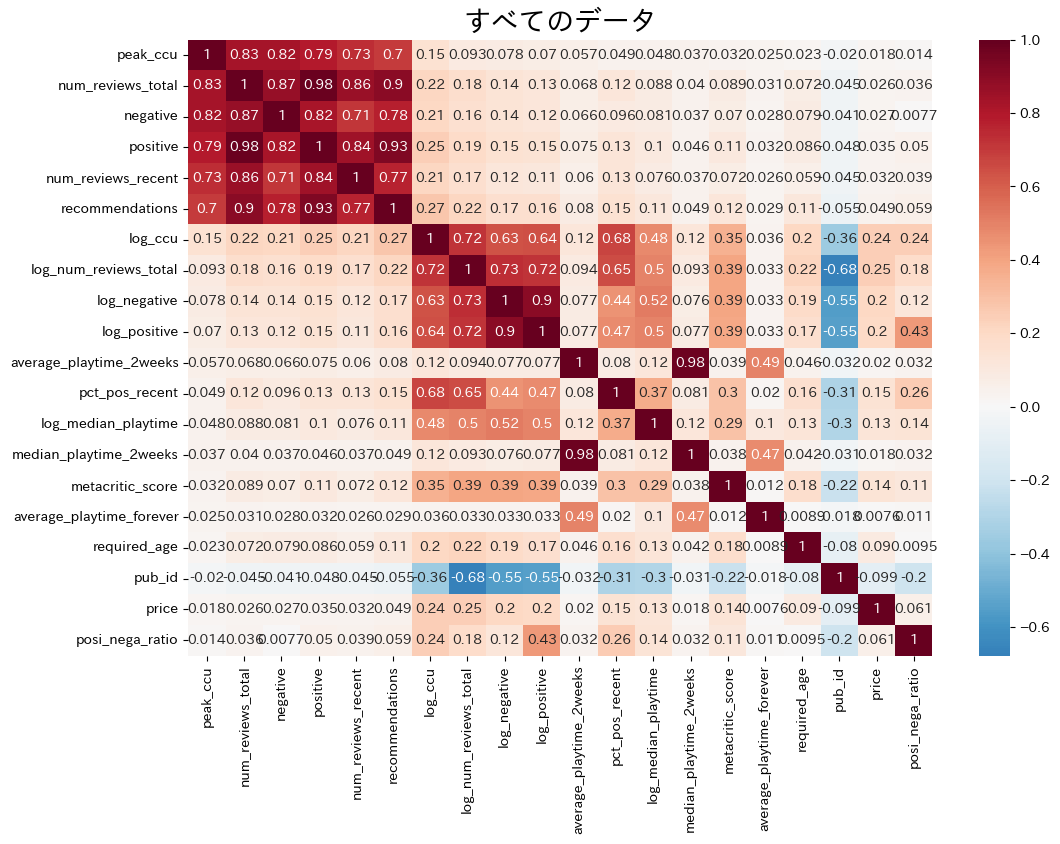

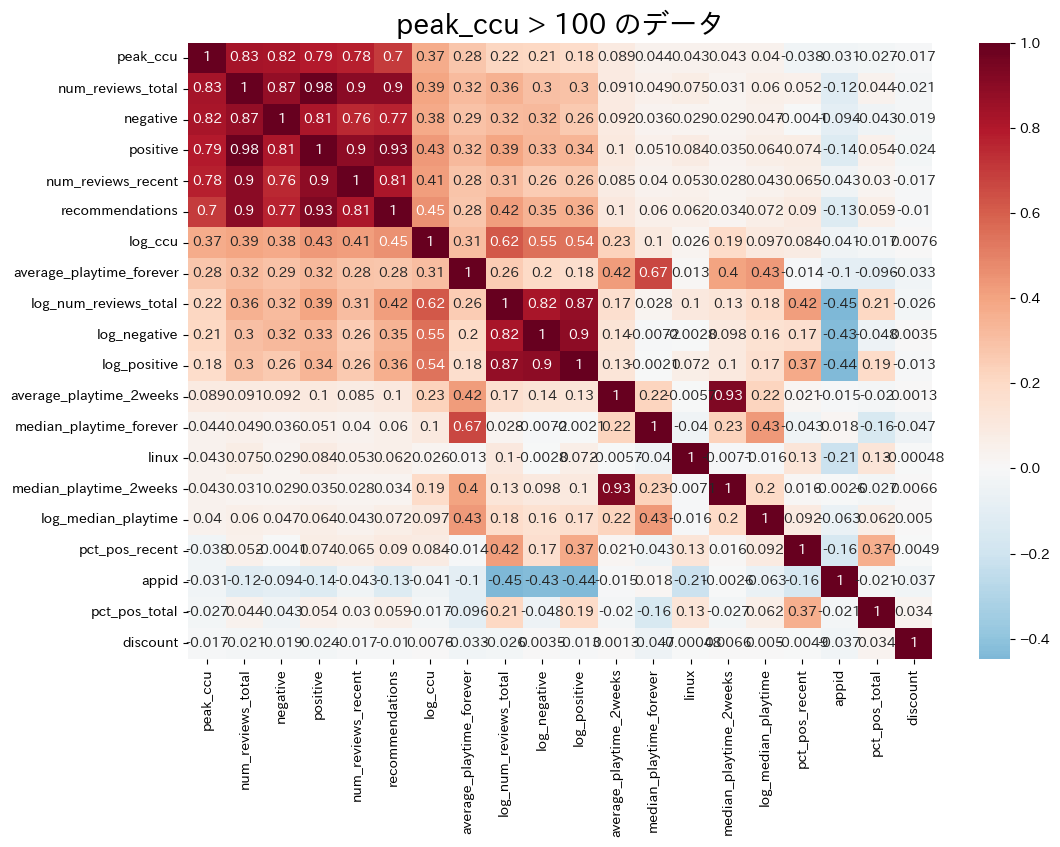

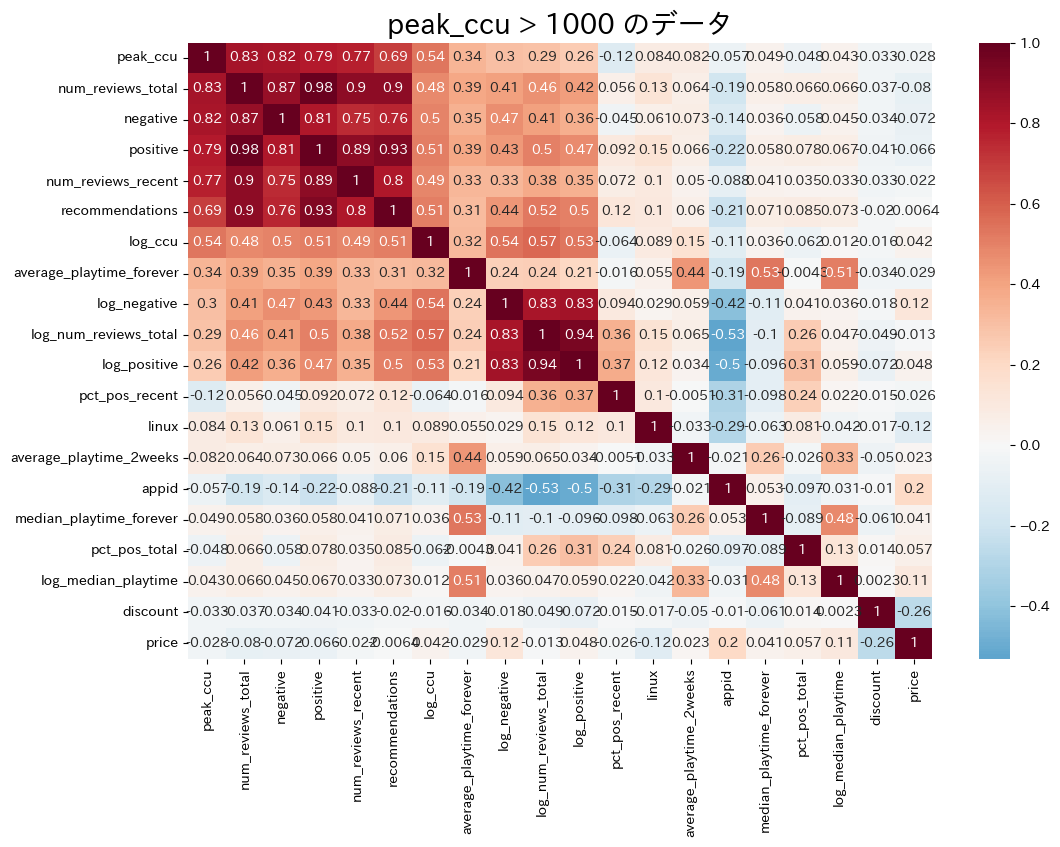

In [6]:
top_corr_cols = df.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 100 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_1000.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_1000[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 1000 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()